In [1]:
import os, sys; sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np

import util.RAVDESS_dataset_util as Rd
import multimodal_vae
from train_mvae import build_model, train

from config_args import ConfigModelArgs, ConfigTrainArgs
import torch_mvae_util as U

In [3]:
cfg_model = ConfigModelArgs()
cfg_train = ConfigTrainArgs()

In [4]:
face_dataset = Rd.FaceEmotionDataset(
    root_dir=cfg_model.dataset_path,
    transform=transforms.Compose
    ([
        Rd.Rescale(cfg_model.img_size), 
        Rd.CenterCrop(cfg_model.img_size), 
        Rd.ToTensor()
    ]))

trainingset_len = len(face_dataset) // 100 * 90
testset_len = len(face_dataset) - trainingset_len
training_dataset, testing_dataset = torch.utils.data.random_split(
    face_dataset, 
    [trainingset_len, testset_len],
    generator=torch.Generator().manual_seed(42)
)

dataset_loader = DataLoader(training_dataset, batch_size=cfg_train.batch_size,
                        shuffle=True, num_workers=cfg_train.num_workers)

testset_loader = DataLoader(testing_dataset, batch_size=cfg_train.batch_size,
                        shuffle=True, num_workers=cfg_train.num_workers)

print('training set size: ',trainingset_len,'\ntest set size: ',testset_len)

training set size:  8820 
test set size:  1047


In [5]:
model_args = {
    'cat_dim' : cfg_model.cat_dim,
    'latent_space_dim' : cfg_model.z_dim,
    'hidden_dim' : cfg_model.hidden_dim,
    'num_channels' : cfg_model.channel_dim,
    'loss_weights' : cfg_model.loss_weights,
    'expert_type' : cfg_model.expert_type,
    'use_cuda' : True
}

model: torch.nn.Module = build_model(**model_args).double()

In [6]:
load_model = False

if load_model:    
    PATH = cfg_train.model_save_path
    loaded_data = torch.load(PATH)
    
    model: torch.nn.Module = build_model(**loaded_data['model_args']).double()
    model.load_state_dict(loaded_data['model_params'])
    
    training_losses = loaded_data['training_loss']
    U.print_losses(training_losses)
    
    model.eval()

100%|███████████████████████| 100/100 [9:31:31<00:00, 342.91s/it]


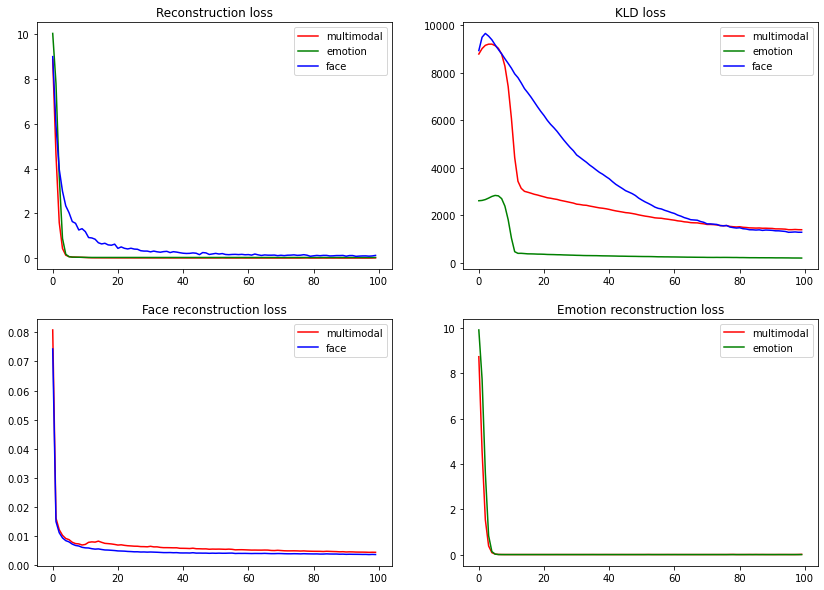

In [7]:
train_model = True

if train_model:
    training_losses = train(
        mvae_model=model,
        dataset_loader=dataset_loader,
        learning_rate=cfg_train.learning_rate,
        optim_betas=cfg_train.optim_betas,
        num_epochs=cfg_train.num_epochs,
        batch_size=cfg_train.batch_size,
        checkpoint_every=cfg_train.checkpoint_every,
        checkpoint_path=cfg_train.checkpoint_path,
        save_model=cfg_train.save_model,
        seed=cfg_train.seed,
        use_cuda=cfg_train.use_cuda,
        cfg=cfg_train
    )
    
    U.print_losses(training_losses)

['disgust', 'happy', 'sad', 'disgust']
['disgust', 'happy', 'sad', 'disgust']


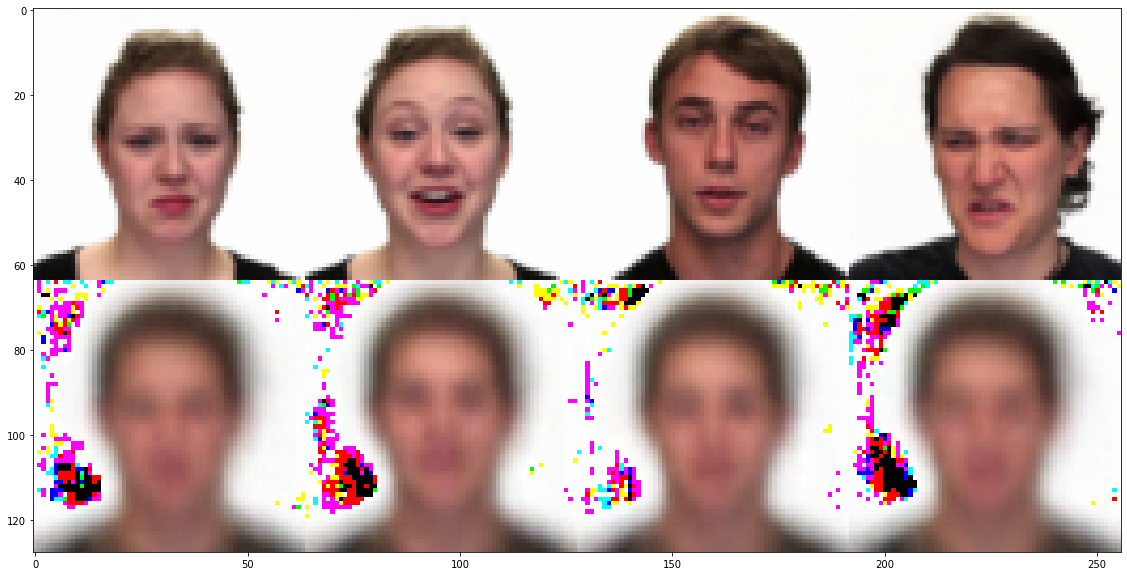

In [8]:
U.test_batch(model, testset_loader)

In [9]:
print(U.recon_and_classiffication_accuracy(model, testset_loader))

100%|██████████████████████████████| 9/9 [00:23<00:00,  2.65s/it]

0.8032473734479465


In [10]:
print(U.recon_and_classiffication_accuracy(model, dataset_loader))

100%|████████████████████████████| 69/69 [01:29<00:00,  1.30s/it]

0.8192743764172336


In [11]:
print(U.classiffication_accuracy(model, testset_loader))

100%|██████████████████████████████| 9/9 [00:22<00:00,  2.50s/it]

0.9465138490926457


In [12]:
print(U.classiffication_accuracy(model, dataset_loader))

100%|████████████████████████████| 69/69 [01:27<00:00,  1.26s/it]

0.999092970521542


In [13]:
save_model = True

if save_model:
    PATH = cfg_train.model_save_path
    torch.save({'model_params' : model.state_dict(),
                'model_args' : model_args,
                'training_loss' : training_losses}, PATH)